#  How to quickly and easily import flat maps into pycortex

Easy (and hacky!!) way to import freesurfer ROIs into pycortex

BEFORE YOU DO THIS MAKE SURE TO BACK UP ANY KIND OF PYCORTEX STUFF YOU DON'T WANT OVERWRITTEN!!!

Why would you do this? Because pycortex is beautiful, but you are lazy... 

It is really nice to be able to toggle the ROIs on and off in pycortex viewer; but to do this you have to have them defined on the svg. To define them on the SVG, you need to draw them in inkscape. But maybe you already used freesurfer, and don't want to... whatever

This helps with that...

It also works with anything defined as a boolean array. 

Also for plotting flatmaps in a pycortex like way but with more flexibility with matplotlib could be useful


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
opj = os.path.join

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# FOR MY OWN TESTING OF THIS EXAMPLE FOLDER
# -> Freesurfer directory
sub = 'sub-02'
fs_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer'

# -> load design matrix, time series and prfpy parameters from one of my projects
# 
from pfa_scripts.load_saved_info import *
prfpy_numpy_array = load_data_prf('sub-02', 'AS0', 'gauss')['AS0']['gauss']
time_series = load_data_tc(sub=sub, ses='ses-1', task_list='AS0', )['AS0']
design_matrix = get_design_matrix_npy(['AS0'])['AS0'][:,:,5:]         

# Create prfpy stimulus & model
assert design_matrix.shape[-1]==time_series.shape[-1]
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,                                    # height of the screen (i.e., the diameter of the stimulated region)    
    screen_distance_cm=196,                                 # Distance of screen to eye
    design_matrix=design_matrix,                            # dm (npix x npix x time_points)
    TR=1.5,                                                 # TR
    )   
prfpy_model = Iso2DGaussianModel(stimulus=prf_stim)

# Now make the "ts plotter": which will make plotting our prf information very easy
prfs  = TSPlotter(
    prf_params=prfpy_numpy_array,
    model='gauss',
    prfpy_model=prfpy_model,
    real_ts=time_series
)

# If you don't want to work with prfpy directly -> just load your own version for some of these
# ** Control visibility of data ** [using mask, or alpha, or both...] 
# If you don't want to show the values of every point (for example because it is outside the visual cortex). You may want to hide it. 
# If you are plotting PRFs, then you may want to hide the bad fits. So you can create a mask for where the rsq<threshold (e.g., 0.1)
# data_mask: what to show (TRUE), what to hide (FALSE)
# -> should boolean 1D np.ndarray, where the length = number of vertices in subject surface
# -> if unspecified, all surface functions assume TRUE for all voxels
# data_alpha: transparency (invisible = 0), (opaque = 1).
# Often you will do this based on the rsquared of your model

polar_angle_data = prfs.pd_params['pol'].to_numpy()
eccentricity_data = prfs.pd_params['ecc'].to_numpy()
data_mask = prfs.return_vx_mask(th={'min-rsq':.1, 'max-ecc':5})
data_rsq = prfs.pd_params['rsq'].to_numpy()
data_alpha = data_rsq.copy()


The nilearn.glm module is experimental. It may change in any future release of Nilearn.


/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-02/ses-1/sub-02_model-gauss_roi-all_task-AS0-fits_stage-iter_constr-tc_desc-prf_params.pkl
prf_params.shape[-1]=8
include hrf = True
include rsq = True


In [4]:
from dag_prf_utils.pycortex import set_ctx_path,PyctxMaker

# Make sure pycortex is pointing to correct folder
# set_ctx_path('/path/to/pycortex/files')

pm = PyctxMaker(
    sub = sub,
    fs_dir = fs_dir, 
    ctx_path=ctx_dir,
    )


Using fs dir = /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/pycortex
default
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/pycortex/sub-02


## quick flatmaps
Already got flatmaps? then skip this stage

Pycortex needs flatmaps. In the form of flat_*h.gii in the pycortex folder for that subject. If you are very lazy (like me) and don't want to go through the trouble of flattening - i offer a couple of DODGY ways  to flatten the surface. 

It involves selecting some of the vertices to focus on. Then applying some kind of flattening algorithm. I then save the stuff into the pycortex folder

In [5]:
import inspect
from dag_prf_utils.utils import dag_load_roi
# Lets pick some vertices to focus on:
# I have drawn a bunch of ROIs in the freesurfer folder
# all called 'custom', so I'll load them
# But you can make this selection anyway you want
centre_bool = dag_load_roi(
    sub=sub,
    roi='v1',
    fs_dir=fs_dir,
    combine_matches=True,  
)

print(f'Number of vertices: {centre_bool.sum()}')
# Boolean array of vertices (in both hemispheres)

Number of vertices: 4905


Make the flatmap 

Basically take the focussing on the coordinates, we can do some flattening. This can be primitively done using the freesurfer projection to a sphere (and just using latitude and longitude). Or you can use the "igl" package which does some clever as-rigid-as-possible transformations. IGL is better, but can fail randomly during the making - so you may have to rerun until you are happy

In [6]:
print(inspect.getsource(pm.make_flat_map))

    def make_flat_map(self, centre_bool=None, **kwargs):
        '''
        Pycotex uses flatmaps for a bunch of things
        But if you can't be bothered to do it properly, and just want
        to display freesurfer ROIs in pycortex you can do this

        Custom method to flatten (not using mris_flatten)
        * option 1: use latitude and longitude
        * option 2: do some clever UV mapping with igl code...

        TODO: remove cut from Y 
        '''

        if not os.path.exists(self.custom_surf_dir):
            os.makedirs(self.custom_surf_dir)
        method = kwargs.pop('method', 'latlon')
        morph = kwargs.pop('morph', 0) # How much to dilate or erode the mask (if doing igl)
        hemi_project = kwargs.get('hemi_project', 'sphere')
        flat_name = kwargs.get('flat_name', 'flat')
        centre_roi = kwargs.get('centre_roi', None)
        if centre_bool is None:
            centre_bool = np.ones_like(self.total_n_vx, dtype=bool)
        centre_bool_hemi =

In [7]:
if True: # DONT DO IT THE SECOND TIME
    pm.mesh_info['occ'] = None
    pm.make_flat_map(
        centre_bool=centre_bool,
        method='igl', # 'igl' or 'latlon'
        hemi_project='inflated', # Starting point for flattening (e.g., inflated, pial, sphere)
        morph=20, # Can expand or shrink the selection on the mesh (dilation/erosion)
        flat_name='v1_iglB',
        cut_box=True, 
    )
    # Morphing is useful to make sure the selection is not too small

centering!
Faces with missing vx: 223544
Faces with long edges: 1197
0.20676758429318629
centering!
Faces with missing vx: 223846
Faces with long edges: 1162
0.20897442240142483
v1_iglB


In [8]:
pm.clear_flat(flat_name='occ')

before we go any further - lets check that it turned out how we would like

{'cmap': 'viridis', 'vmin': -99.63888549804688, 'vmax': 98.75199127197266}

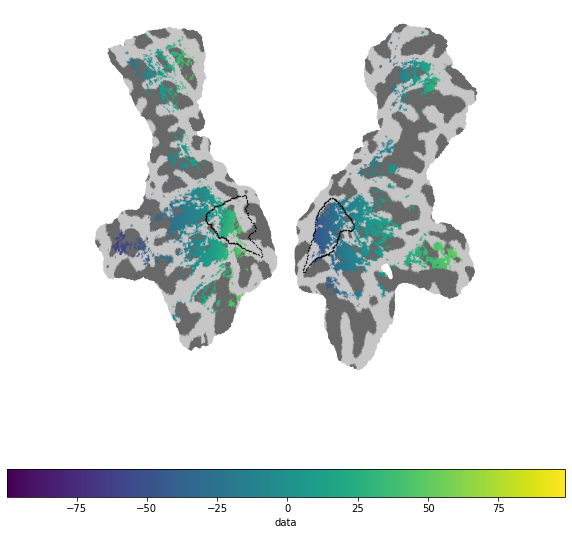

In [9]:
# This is not the same as pycortex's quickshow
# pm.reload_flat('v1_igl')
x = np.hstack(
    [
        pm.mesh_info['sphere']['lh']['coords'][:,0],
        pm.mesh_info['sphere']['rh']['coords'][:,0]
    ]) 
pm.flat_mpl(
    data=x, #cmap='marco_pol', vmin=-np.pi, vmax=np.pi,
    data_mask=data_mask,
    flat_name='flat',
    roi_list='v1c', 
    # angle_rot=0  
    )

Above i use my own flat_mpl but to get this to work with pycortex you need to kill the kernel and rerun the notebook. up to this point

## Add the ROIs to pycortex SVG (Kill kernel and rerun first!)
To add ROIs we 

[1] Load the boolean array from freesurfer

[2] Find the vertices on the edge of ROIs

[3] Find the order for these vertices 

[4] Draw them onto our SVG file


Again I've written this so you can do it just using this line of code

In [10]:
roi_list = ['v1', ]  # roi names in you're freesurfer label folder
pm.add_rois_to_svg(roi_list)

Just using undersurface file..
(inkscape:957956): Gtk-WARNING **: 11:02:39.814: GTK+ module /usr/lib64/gtk-2.0/modules/libpk-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 11:02:39.814: Failed to load module "pk-gtk-module"
(inkscape:957956): Gtk-WARNING **: 11:02:39.820: GTK+ module /usr/lib64/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 11:02:39.820: Failed to load module "canberra-gtk-module"
(inkscape:957956): Gtk-WARNING **: 11:02:39.822: GTK+ module /usr/lib64/gtk-2.0/modules/libpk-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 11:02:39.822: Failed to load module "pk-gtk-module"
(inkscape:957956): Gtk-WARNING **: 11:02:39.822: GTK+ module /usr/lib64/gtk-2.0/modules/libcanberra-gtk-module.

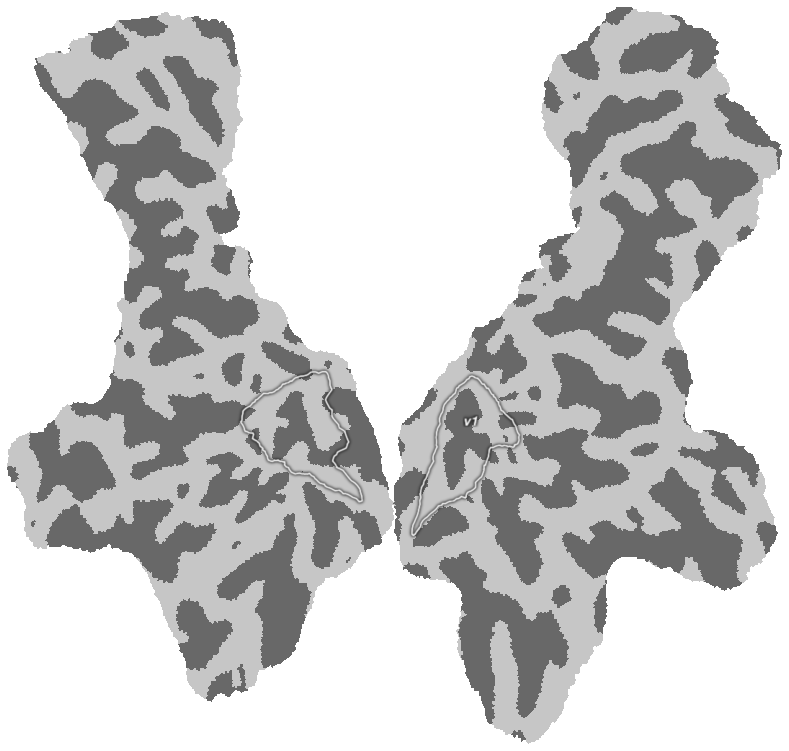

In [11]:

pm.quick_show()